<a href="https://colab.research.google.com/github/MaralAIHub/ML_Portfolio/blob/main/IMDB_Semantic_Analysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **تحلیل احساسات با LSTM روی IMDB**

**بارگذاری کتابخانه ها**

In [1]:
import re
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


**بارگذاری داده**

In [2]:
dataset = load_dataset("imdb")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


**توکنایزر ساده**

In [3]:
def tokenize(text):
    return re.findall(r"\w+", text.lower())

# ساخت واژگان (vocab)
counter = Counter()
for txt in dataset["train"]["text"]:
    counter.update(tokenize(txt))

VOCAB_SIZE = 20000   # حداکثر اندازه واژگان
most_common = counter.most_common(VOCAB_SIZE)

vocab = {"<pad>":0, "<unk>":1}
for i, (tok, _) in enumerate(most_common, start=2):
    vocab[tok] = i

pad_idx = vocab["<pad>"]
unk_idx = vocab["<unk>"]
vocab_size = len(vocab)
print("Vocab size:", vocab_size)

# تبدیل متن به لیست عددی
def encode(text):
    return [vocab.get(t, unk_idx) for t in tokenize(text)]

Vocab size: 20002


**collate_fn برای DataLoader**

In [4]:
def collate_batch(batch):
    texts = [torch.tensor(encode(item["text"]), dtype=torch.long) for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
    texts_padded = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)
    return labels, texts_padded

train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(dataset["test"],  batch_size=64, shuffle=False, collate_fn=collate_batch)

**تعریف مدل LSTM**

In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, output_dim=2, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        embedded = self.embedding(x)                # (B, L, E)
        _, (hidden, _) = self.lstm(embedded)        # hidden: (num_layers, B, H)
        out = self.fc(self.dropout(hidden[-1]))     # آخرین لایه LSTM
        return out

model = LSTMClassifier(vocab_size=vocab_size, pad_idx=pad_idx).to(device)
print(model)

LSTMClassifier(
  (embedding): Embedding(20002, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


**آموزش**

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 2   # برای تست سریع، بیشتر کنید برای دقت بالاتر
history = {"loss":[], "acc":[]}

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct = total = 0
    for labels, texts in train_loader:
        labels = labels.to(device)
        texts = texts.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss/len(train_loader)
    acc = correct/total
    history["loss"].append(avg_loss)
    history["acc"].append(acc)
    print(f"Epoch {epoch+1}  Loss={avg_loss:.3f}  Acc={acc:.3f}")

Epoch 1  Loss=0.693  Acc=0.502
Epoch 2  Loss=0.692  Acc=0.507


**نمودار آموزش**

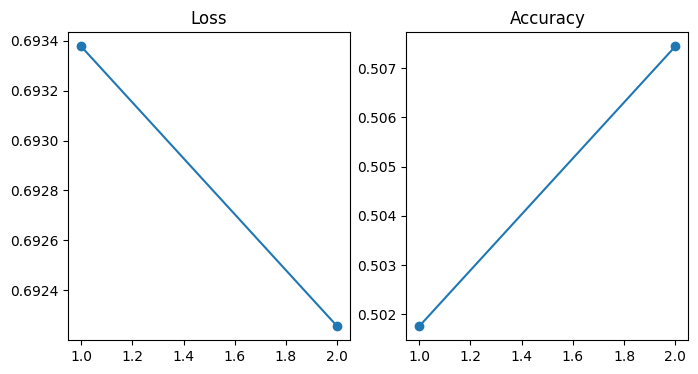

In [7]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), history["loss"], marker='o')
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), history["acc"], marker='o')
plt.title("Accuracy")
plt.show()

**پیش‌بینی روی جمله جدید**

In [8]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        ids = torch.tensor(encode(text), dtype=torch.long).unsqueeze(0).to(device)
        out = model(ids)
        probs = F.softmax(out, dim=1).cpu().numpy()[0]
        return probs

examples = ["This movie was amazing!", "I hated this movie, it was so boring."]
for s in examples:
    p = predict_sentiment(s)
    print(s, "-> neg:{:.2f}, pos:{:.2f}".format(p[0], p[1]))


This movie was amazing! -> neg:0.40, pos:0.60
I hated this movie, it was so boring. -> neg:0.42, pos:0.58
